In [2]:
import torch

from PIL import Image
import numpy as np

from diffusers import StableDiffusionPipeline

In [3]:
import io
import typing as T

import numpy as np
from PIL import Image
import pydub
from scipy.io import wavfile
import torch
import torchaudio


def wav_bytes_from_spectrogram_image(image: Image.Image) -> T.Tuple[io.BytesIO, float]:
    """
    Reconstruct a WAV audio clip from a spectrogram image. Also returns the duration in seconds.
    """

    max_volume = 50
    power_for_image = 0.25
    Sxx = spectrogram_from_image(image, max_volume=max_volume, power_for_image=power_for_image)

    sample_rate = 44100  # [Hz]
    clip_duration_ms = 5000  # [ms]

    bins_per_image = 512
    n_mels = 512

    # FFT parameters
    window_duration_ms = 100  # [ms]
    padded_duration_ms = 400  # [ms]
    step_size_ms = 10  # [ms]

    # Derived parameters
    num_samples = int(image.width / float(bins_per_image) * clip_duration_ms) * sample_rate
    n_fft = int(padded_duration_ms / 1000.0 * sample_rate)
    hop_length = int(step_size_ms / 1000.0 * sample_rate)
    win_length = int(window_duration_ms / 1000.0 * sample_rate)

    samples = waveform_from_spectrogram(
        Sxx=Sxx,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        num_samples=num_samples,
        sample_rate=sample_rate,
        mel_scale=True,
        n_mels=n_mels,
        max_mel_iters=200,
        num_griffin_lim_iters=32,
    )

    wav_bytes = io.BytesIO()
    wavfile.write(wav_bytes, sample_rate, samples.astype(np.int16))
    wav_bytes.seek(0)

    duration_s = float(len(samples)) / sample_rate

    return wav_bytes, duration_s


def spectrogram_from_image(
    image: Image.Image, max_volume: float = 50, power_for_image: float = 0.25
) -> np.ndarray:
    """
    Compute a spectrogram magnitude array from a spectrogram image.
    TODO(hayk): Add image_from_spectrogram and call this out as the reverse.
    """
    # Convert to a numpy array of floats
    data = np.array(image).astype(np.float32)

    # Flip Y take a single channel
    data = data[::-1, :, 0]

    # Invert
    data = 255 - data

    # Rescale to max volume
    data = data * max_volume / 255

    # Reverse the power curve
    data = np.power(data, 1 / power_for_image)

    return data


def spectrogram_from_waveform(
    waveform: np.ndarray,
    sample_rate: int,
    n_fft: int,
    hop_length: int,
    win_length: int,
    mel_scale: bool = True,
    n_mels: int = 512,
) -> np.ndarray:
    """
    Compute a spectrogram from a waveform.
    """

    spectrogram_func = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        power=None,
        hop_length=hop_length,
        win_length=win_length,
    )

    waveform_tensor = torch.from_numpy(waveform.astype(np.float32)).reshape(1, -1)
    Sxx_complex = spectrogram_func(waveform_tensor).numpy()[0]

    Sxx_mag = np.abs(Sxx_complex)

    if mel_scale:
        mel_scaler = torchaudio.transforms.MelScale(
            n_mels=n_mels,
            sample_rate=sample_rate,
            f_min=0,
            f_max=10000,
            n_stft=n_fft // 2 + 1,
            norm=None,
            mel_scale="htk",
        )

        Sxx_mag = mel_scaler(torch.from_numpy(Sxx_mag)).numpy()

    return Sxx_mag


def waveform_from_spectrogram(
    Sxx: np.ndarray,
    n_fft: int,
    hop_length: int,
    win_length: int,
    num_samples: int,
    sample_rate: int,
    mel_scale: bool = True,
    n_mels: int = 512,
    max_mel_iters: int = 200,
    num_griffin_lim_iters: int = 32,
    device: str = "cuda:0",
) -> np.ndarray:
    """
    Reconstruct a waveform from a spectrogram.
    This is an approximate inverse of spectrogram_from_waveform, using the Griffin-Lim algorithm
    to approximate the phase.
    """
    Sxx_torch = torch.from_numpy(Sxx).to(device)

    # TODO(hayk): Make this a class that caches the two things

    if mel_scale:
        mel_inv_scaler = torchaudio.transforms.InverseMelScale(
            n_mels=n_mels,
            sample_rate=sample_rate,
            f_min=0,
            f_max=10000,
            n_stft=n_fft // 2 + 1,
            norm=None,
            mel_scale="htk",
            max_iter=max_mel_iters,
        ).to(device)

        Sxx_torch = mel_inv_scaler(Sxx_torch)

    griffin_lim = torchaudio.transforms.GriffinLim(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=1.0,
        n_iter=num_griffin_lim_iters,
    ).to(device)

    waveform = griffin_lim(Sxx_torch).cpu().numpy()

    return waveform


def mp3_bytes_from_wav_bytes(wav_bytes: io.BytesIO) -> io.BytesIO:
    mp3_bytes = io.BytesIO()
    sound = pydub.AudioSegment.from_wav(wav_bytes)
    sound.export(mp3_bytes, format="mp3")
    mp3_bytes.seek(0)
    return mp3_bytes

def image_from_spectrogram(spectrogram: np.ndarray, max_volume: float = 50, power_for_image: float = 0.25) -> Image.Image:
    """
    Compute a spectrogram image from a spectrogram magnitude array.
    """
    # Apply the power curve
    data = np.power(spectrogram, power_for_image)

    # Rescale to 0-255
    data = data * 255 / max_volume

    # Invert
    data = 255 - data

    # Convert to a PIL image
    image = Image.fromarray(data.astype(np.uint8))

    # Flip Y
    image = image.transpose(Image.FLIP_TOP_BOTTOM)

    # Convert to RGB
    image = image.convert("RGB")

    return image

In [4]:
device = "cuda"
MODEL_ID = "riffusion/riffusion-model-v1"
pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID, torch_dtype=torch.float16)
pipe = pipe.to(device)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/home/hu/miniconda3/envs/th/lib/python3.8/site-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: The configuration file of the unet has set the default `sample_size` to smaller than 64 which seems highly unlikely .If you're checkpoint is a fine-tuned version of any of the following: 
- CompVis/stable-diffusion-v1-4 
- CompVis/stable-diffusion-v1-3 
- CompVis/stable-diffusion-v1-2 
- CompVis/stable-diffusion-v1-1 
- runwayml/stable-diffusion-v1-5 
- runwayml/stable-diffusion-inpainting 
 you should change 'sample_size' to 64 in the configuration file. Please make sure to update the config accordingly as leaving `sample_size=32` in the config might lead to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for the `unet/config.json` file
  warnings.warn(warning + message, FutureWarning)


In [5]:
def classic(prompt, negative_prompt, duration):
    if duration == 5:
        width_duration=512
    else :
        width_duration = 512 + ((int(duration)-5) * 128)
    spec = pipe(prompt, negative_prompt=negative_prompt, height=512, width=width_duration).images[0]
    print(spec)
    wav = wav_bytes_from_spectrogram_image(spec)
    # with open("output.wav", "wb") as f:
    #     f.write(wav[0].getbuffer())
    return spec, wav

In [6]:
def image_from_spectrogram(
    spectrogram: np.ndarray, max_volume: float = 50, power_for_image: float = 0.25
) -> Image.Image:
    """
    Compute a spectrogram image from a spectrogram magnitude array.
    """
    # Apply the power curve
    data = np.power(spectrogram, power_for_image)

    # Rescale to 0-255
    data = data * 255 / max_volume

    # Invert
    data = 255 - data

    # Convert to a PIL image
    image = Image.fromarray(data.astype(np.uint8))

    # Flip Y
    image = image.transpose(Image.FLIP_TOP_BOTTOM)

    # Convert to RGB
    image = image.convert("RGB")

    return image

In [7]:
a,b = classic('piano, classical, pop', 'electric', 5)

  0%|          | 0/51 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=512x512 at 0x7F9D601C8910>


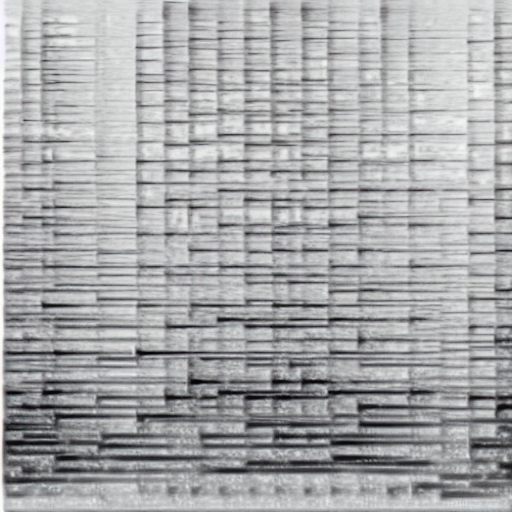

In [8]:
a

In [9]:
with open("output_rif.wav", "wb") as f:
    f.write(b[0].getbuffer())

In [11]:
from IPython.display import Audio
display(Audio('output_rif.wav', rate=44100))

In [30]:
torchaudio.load('output.wav')

(tensor([[0.0006, 0.0005, 0.0004,  ..., 0.1040, 0.0976, 0.0943]]), 44100)